# 1- Drive Bağlantısı

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2- Kütüphaneler

In [3]:
!pip install pymap3d pyproj

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00


In [4]:
# 1. Matematik ve Sayısal İşlemler
import math
import numpy as np
import scipy.optimize # Optimizasyon işlemleri için
from scipy.spatial import distance # İki nokta arasındaki mesafeleri hesaplamak için.
from scipy import signal #  Sinyal işleme fonksiyonları için
from scipy.interpolate import InterpolatedUnivariateSpline # Veriler üzerinde spline interpolasyonu yapmak için. Yani; noktalar arasında düzgün, kesintisiz ve pürüzsüz eğriler oluşturur.

# 2. Görselleştirme ve Veri Analizi
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px # Etkileşimli ve daha gelişmiş görselleştirmeler için.
import plotly.graph_objects as go # Etkileşimli ve daha gelişmiş görselleştirmeler için.

# 3. Coğrafi Hesaplamalar
import pymap3d as pm # GNSS konum verilerinin dönüştürülmesi ve Vincenty formülleri ile mesafe hesaplamaları için.
import pymap3d.vincenty as pmv #GNSS konum verilerinin dönüştürülmesi ve Vincenty formülleri ile mesafe hesaplamaları için.
import pyproj as proj # Coğrafi projeksiyonlar ve dönüşümler için.

# 4. Makine Öğrenimi ve Derin Öğrenme
from tensorflow import keras # Derin öğrenme modelleri oluşturmak ve eğitmek için.
from keras import layers # Yapay sinir ağları katmanlarını tanımlamak ve oluşturmak için .
from keras import models # Yapay sinir ağları modellerini tanımlamak ve oluşturmak için.

# 5. Dosya ve İlerleme Takibi
import glob as gl # Dosya sistemi ile çalışmak ve belirli desenlere uyan dosyaları bulmak için.
from tqdm.auto import tqdm # Uzun süren işlemlerde  ilerleme çubuğu oluşturmak için.

# 6. Gereksiz Uyarıları Görmeme
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Sabitler
CLIGHT = 299_792_458   # Işık Hızı (m/s). GNSS sinyallerinin uydu ile alıcı arasında hareket etme hızını temsil edecek.
RE_WGS84 = 6_378_137   # Dünya Yarıçapı (WGS84 yöntemiyle ölçülmüştür) (m). Dünya'nın WGS84 referans elipsoidine göre ekvator yarıçapını temsil edecek.
OMGE = 7.2921151467E-5  # Dünya'nın Açısal Hızı (rad/s). Dünya'nın kendi ekseni etrafındaki dönüş hızını temsil eder.  Konum hesaplamalarında kullanılır.

# 3- Uydu Seçimi

Bu fonksiyon, bir GNSS veri çerçevesinden (ör. device_gnss.csv dosyasından alınan veriler) belirli kriterlere göre uydu sinyallerini seçmek için kullanılacaktır.

Fonksiyon, aşağıdaki ölçütlere uymayan uydu sinyallerini filtreleyerek daha güvenilir veriler elde edilmesini sağlar:
- **Taşıyıcı frekans hatası (CarrierErrorHz) 2 MHz'ten küçük olmalı.** Çünkü, GNSS sinyallerinde taşıyıcı frekans hatasının küçük olması, sinyalin doğru bir şekilde alınması için önemlidir. 2 MHz üzerindeki hatalar genellikle sinyaldeki parazit veya sapmalardan kaynaklanır ve güvenilir veri elde edilmesini zorlaştırır.

- **Uydu eğim açısı (SvElevationDegrees) 10 dereceden büyük olmalı.** Çünkü, 10 derece altındaki açılar veya 15 derece üstündeki açılar, sinyalin atmosferik etkilerden (örneğin troposferik kırılma ya da bir diğer deyişle GPS uydusunun sinyalinin varışındaki gecikme) daha fazla etkilenmesine neden olabilir. Ayrıca, alıcıya gelen sinyalin zayıf olması düşük eğim açılarında daha olasıdır.

- **Taşıyıcı-gürültü oranı (Cn0DbHz) 15 dB-Hz'den büyük olmalı.** Çünkü, Taşıyıcı-gürültü oranı, sinyal kalitesini gösteren önemli bir metriktir. 15 dB-Hz altındaki sinyaller zayıf olarak kabul edilir ve konum belirleme doğruluğunu olumsuz etkileyebilir.

- **Çoklu yol etkisi (MultipathIndicator) olmadığını belirtmeli.** Çünkü, Çoklu yol etkisi, GNSS sinyallerinin yüzeylerden yansıması sonucu farklı yollardan alıcıya ulaşmasıdır. Bu durum, sinyalin doğruluğunu ciddi şekilde bozabilir. Bu nedenle, yalnızca doğrudan gelen sinyaller seçilmelidir.

Bu fonksiyonu yazmamızdaki sebep, GNSS sinyallerinin doğruluğunu artırmak ve hatalı sinyallerden kaynaklanan sapmaları azaltmaktır.

In [5]:
# GNSS veri çerçevesinden uydu sinyallerini belirli kriterlere göre filtreleyen fonksiyon
def satellite_selection(df, column):
    """
    Bu fonksiyon, GNSS veri çerçevesinden belirli kriterlere uymayan uydu sinyallerini filtreler.

    Args:
        df : DataFrame from device_gnss.csv
            GNSS ölçümlerini içeren veri çerçevesi.
        column : str
            Sinyallerin filtreleneceği sütunun adı.

    Returns:
        df : DataFrame
            Belirtilen kriterlere uyan uydu sinyallerini içeren filtrelenmiş veri çerçevesi geri döndürülecek.
    """
    # Null olmayan değerlerle çalışmak için
    idx = df[column].notnull()

    # Taşıyıcı frekans hatası (CarrierErrorHz) 2 MHz'ten küçük olmalı. Çünkü:
    #  - GNSS sinyallerinde taşıyıcı frekans hatasının küçük olması, sinyali doğru bir şekilde almamız için önemlidir.
    #  - 2 MHz üzerindeki hatalar genellikle sinyaldeki parazit veya sapmalardan kaynaklanır ve güvenilir veriyi elde etmemizi zorlaştırır.
    idx &= df['CarrierErrorHz'] < 2.0e6

    # Uydu eğim açısı (SvElevationDegrees) 10 ila 15 derece arasında olmalı. Çünkü:
    #  - 10 derece altındaki açılar, sinyalin atmosferik etkilerden (örneğin troposferik kırılma - sinyaldeki gecikme) daha fazla etkilenmesine neden olabilir.
    #  - Ayrıca,  eğim açısı düştükçe alıcıya gelen sinyalin zayıflaması daha olasıdır.
    idx &= df['SvElevationDegrees'] > 10.0

    # Taşıyıcı-gürültü oranı (C/N0) 15 dB-Hz'den büyük olmalı. Çünkü:
    # - Taşıyıcı-gürültü oranı, sinyal kalitesini gösteren önemli bir metriktir.
    # - 15 dB-Hz altındaki sinyaller zayıf olarak kabul edilir ve konum belirleme doğruluğunu olumsuz etkileyebilir.
    idx &= df['Cn0DbHz'] > 15.0

    # Çoklu yol etkisi (MultipathIndicator = 0) olmamalı. Çünkü:
    # - Çoklu yol etkisi, GNSS sinyallerinin yüzeylerden yansıması sonucu farklı yollardan alıcıya ulaşmasıdır.
    # - Bu durum, sinyalin doğruluğunu ciddi şekilde bozabilir. Bu nedenle, yalnızca doğrudan gelen sinyaller seçilmeli , yüzeyden seken sinyalleri egale etmeliyiz.
    idx &= df['MultipathIndicator'] == 0

    # Belirtilen kriterlere uyan satırları döndür
    return df[idx]


# 4- Uydu Sinyallerinden Yeryüzündeki Bir Kullanıcının Konumunu ve Hızını Hesaplama (Weighted Least Squares / Ağırlıklı En Küçük Kareler Yönemi İle)

In [6]:
def point_positioning(gnss_df):
    # Her uydu (Svid) ve sinyal tipi (SignalType) için taşıyıcı frekansı (CarrierFrequencyHz) sütunundaki medyan değerleri hesaplıyoruz.
    CarrierFrequencyHzRef = gnss_df.groupby(['Svid', 'SignalType'])['CarrierFrequencyHz'].median()
    # Yukarıda oluştruduğumuz her medyan değerini, orijinal GNSS verileriyle birleştirdik
    gnss_df = gnss_df.merge(CarrierFrequencyHzRef, how='left', on=['Svid', 'SignalType'], suffixes=('', 'Ref'))

    # Üstte Hesapladığım CarrierFrequencyHzRef ile veri setinde bulunan CarrierFrequencyHz arasındaki farkı bularak taşıyıcı frekansı hatasını (CarrierErrorHz) hesapladık ...
    # ... ve veri setimizde 'CarrierErrorHz' sütununu ekledik
    # Çünkü başlarda da bahsettiğimiz gibi Taşıyıcı frekans hatası (CarrierErrorHz) 2 MHz'ten küçük olursa işimize yarayacak
    gnss_df['CarrierErrorHz'] = np.abs((gnss_df['CarrierFrequencyHz'] - gnss_df['CarrierFrequencyHzRef']))

    # Pseudorange verisini (gerçek mesafe ölçümünden elde edilen değer) Carrier Smoothing (taşıyıcı-pürüzsüzleştirme) yöntemiyle düzgünleştirdik.
    # Basitçe Carrier Smoothing: pseudorange verisinin doğruluğunu artırmak için kullanılan bir tekniktir. Verilerdeki gürültüyü azaltır ve daha doğru yer belirleme (positioning) sağlar
    gnss_df = carrier_smoothing(gnss_df)

    # Benzersiz zaman damgalarını alacak ve toplam iterasyon sayısını hesaplayacağız. Yani, kaç farklı zaman noktasının (epoch) veri setinde bulunduğunu göstereceğiz
    utcTimeMillis = gnss_df['utcTimeMillis'].unique() # "utcTimeMillis", her bir veri kaydının zamanını milisaniye cinsinden temsil ediyor.
    nepoch = len(utcTimeMillis)  # Toplam iterasyon sayısı

    # Pozisyon ve hız için başlangıç vektörlerini tanımladık
    x0 = np.zeros(4)  # Başlangıç pozisyon [x, y, z, saat] -> her birine ilk değer olarak 0 atadık
    v0 = np.zeros(4)  # Başlangıç hız [vx, vy, vz, saat] -> her birine ilk değer olarak 0 atadık

    # Pozisyon ve hız tahminlerini kayıt etmek için matrisler oluşturacağız
    x_wls = np.full([nepoch, 3], np.nan)  # Pozisyon tahminlerini kaydetmek için
    v_wls = np.full([nepoch, 3], np.nan)  # Hız tahminlerini kaydetmek için


    for i, (t_utc, df) in enumerate(tqdm(gnss_df.groupby('utcTimeMillis'), total=nepoch)):
        # Geçerli uydu sinyallerini Pseudorange verisi için seçelim
        df_pr = satellite_selection(df, 'pr_smooth')
        # Geçerli uydu sinyallerini Pseudorange Rate verisi için seçelim
        df_prr = satellite_selection(df, 'PseudorangeRateMetersPerSecond')  # PseudorangeRateMetersPerSecond, pseudorange'nin zamanla değişme hızını (yani, alıcı ile uydu arasındaki mesafenin hızını) ifade eder.

        # GNSS verisindeki pseudorange hatalarını düzeltmek için gerekli düzenlemeler yapacağız:
        # - SvClockBiasMeters: Uydu saatinin yanlışı (saat kayması)
        # - IsrbMeters:  uydunun yerçekimi, ortam koşulları veya diğer etmenler nedeniyle oluşan küçük sapmaları ifade eder
        # - IonosphericDelayMeters (İyonosferik Gecikme): GNSS sinyalleri, iyonosferdeki serbest elektron yoğunluğu nedeniyle hız kaybına uğrar.
        # - TroposphericDelayMeters (Troposferik Gecikme): Troposferdeki nem, sıcaklık ve basınç faktörler,, GNSS sinyallerini etkileyebilir ve bu da sinyallerin alıcıya ulaşma süresini uzatır.
        pr = (df_pr['pr_smooth'] + df_pr['SvClockBiasMeters'] - df_pr['IsrbMeters'] - df_pr['IonosphericDelayMeters'] - df_pr['TroposphericDelayMeters']).to_numpy()

        # Pseudorange Rate (Pseudorange Hızı) ve SvClock Drift (Uydu Saat Kayması) verilerini birleştirilerek, düzeltilmiş Pseudorange Rate elde edeceğiz.
        prr = (df_prr['PseudorangeRateMetersPerSecond'] + df_prr['SvClockDriftMetersPerSecond']).to_numpy()

        # Uydu pozisyon verilerini Pseudorange verisi için alacağız:
        #  - ECEF (Earth-Centered, Earth-Fixed): Dünya merkezine dayalı bir koordinat sistemidir.
        xsat_pr = df_pr[['SvPositionXEcefMeters', 'SvPositionYEcefMeters','SvPositionZEcefMeters']].to_numpy()

        # Uydu pozisyon verilerini Pseudorange Rate verisi için hız için alacağız
        xsat_prr = df_prr[['SvPositionXEcefMeters', 'SvPositionYEcefMeters','SvPositionZEcefMeters']].to_numpy()

        # Uydu hız verilerini Pseudorange Rate verisi için alacağız
        vsat = df_prr[['SvVelocityXEcefMetersPerSecond', 'SvVelocityYEcefMetersPerSecond','SvVelocityZEcefMetersPerSecond']].to_numpy()

        # Pseudorange ve Pseudorange Rate için ağırlık matrislerini hesaplayacağız
        # Buradaki "1 / df_pr['RawPseudorangeUncertaintyMeters']" işlemi:
        # Her bir belirsizliğin tersini alır. Belirsizliğin tersten alınması, daha düşük belirsizliğe sahip ölçümlere daha fazla ağırlık verir...
        # ... Yüksek belirsizlik, düşük ağırlık anlamına gelir. Yani, güvenilir olmayan ölçümler daha düşük bir ağırlığa sahip olmalı.
        Wx = np.diag(1 / df_pr['RawPseudorangeUncertaintyMeters'].to_numpy())
        Wv = np.diag(1 / df_prr['PseudorangeRateUncertaintyMetersPerSecond'].to_numpy())


        # Artık kullanıcının POZİSYON TAHMİNİNİ yapabiliriz

        if len(df_pr) >= 4:  # Konumu doğru belirleyebilmek için en az 4 uydu gerekir -> 3D konum + zaman
            if np.all(x0 == 0):  # Başlangıç tahmini 0 ise
                # Bu kısımda, LEAST SQUARES (en küçük kareler) yöntemi kullanılarak pozisyon tahmini yapacağız:
                # - pr_residuals: Bu fonksiyon, modelle uydu ölçümleri arasındaki farkları hesaplayacak. (residuals = artık)
                # - jac_pr_residuals: ölçüm hatalarının (residul) türevini alarak doğrusal olmayan optimizasyonun yapılmasını sağlar.
                # - xsat_pr: Uyduların konum verilerini içeren NumPy dizisi.
                # - pr: Pseudorange (mesafe ölçüm) verileri.
                # - Wx: Pseudorange belirsizliklerine dayalı ağırlık matrisi.
                opt = scipy.optimize.least_squares(pr_residuals, x0, jac_pr_residuals, args=(xsat_pr, pr, Wx))

                # Daha sonra yukarıda optimize edilen pozisyonu güncel pozisyonumuz olarak güncelledik
                x0 = opt.x

            # Normal WLS'ten sonra Robust (dayanıklı) WLS ile pozisyon tahmini yaparak ölçüm doğruluğunu arttıracağız:
            # Burada" soft_l1" loss fonksiyonu kullanılarak, pozisyon tahmini yapılırken daha az güvenilir ölçümlerin etkisi azaltılmak istiyoruz.
            opt = scipy.optimize.least_squares(pr_residuals, x0, jac_pr_residuals, args=(xsat_pr, pr, Wx), loss='soft_l1')


            # Optimizasyonun durumunu kontrol ederek başarılı mı başarısız mı diye bakalım
            # - (0) = Başarılı optimizasyon
            # - (1) = Başarıyla tamamlanmış ancak istenen hassasiyete ulaşılmamış.
            # - (2) = Optimizasyon başarıyla tamamlanmış ancak maksimum iterasyon sayısına ulaşılmış. Yani, çözüme ulaşmak için daha fazla iterasyon yapılabilirdi ancak durdurulmuş.
            # - (-1): Başarısızlık, optimizasyonun çözüme ulaşamadığı durum.
            # - (-2): Başarısızlık.
            if opt.status < 1 or opt.status == 2:
                print(f'i = {i} KONUM optimizasyon durumu = {opt.status}')

            else:
              # Eğer optimizasyon başarılı bir şekilde tamamlanmışsa, tahmin edilen pozisyon (opt.x) alınır ve x_wls'ye kaydedilir.
              # Buradaki opt.x[:3] kısmı, elde edilen 4 elemanlı çözüm vektörünün (3D + Zaman) ilk 3 elemanını (x, y, z koordinatlarını) alır.
                x_wls[i, :] = opt.x[:3]  # Tahmin edilen pozisyonu kaydet
                x0 = opt.x  # Pozisyonu güncelle




        # Kullanıcının HIZ TAHMİNİNİ de yapabliriz

        # Üstte konum için yaptığımız tüm işlemlerin aynısını hız için de yapacağız
        if len(df_prr) >= 4:  # En az 4 uydu verisi gerekli demiştik
            if np.all(v0 == 0):  # Başlangıç tahmini yoksa normal WLS ile başla
                opt = scipy.optimize.least_squares(prr_residuals, v0, jac_prr_residuals, args=(vsat, prr, x0, xsat_prr, Wv))
                v0 = opt.x  # Optimize edilen hızı güncelledik
            # Robust (Dayanıklı) WLS ile hız tahmini yaptık
            opt = scipy.optimize.least_squares(prr_residuals, v0, jac_prr_residuals, args=(vsat, prr, x0, xsat_prr, Wv), loss='soft_l1')
            if opt.status < 1:  # Yİne optimizaston durumlarını kontrol edeceğiz
                print(f'i = {i} HIZ optimizasyon durumu = {opt.status}')
            else:
                v_wls[i, :] = opt.x[:3]  # Tahmin edilen hızı kaydet
                v0 = opt.x  # Hızı güncelle

    # Tahmin edilen zaman, pozisyon ve hız değerlerini döndür
    return utcTimeMillis, x_wls, v_wls


# 5- Carrier Smoothing (Taşıyıcı Pürüzsüzleştirme) ile Pseudorange (Gerçek Mesafa , Konum/Hız Tahmini) Tahmininin Doğruluğunu Artırma

Bu fonksiyon, GNSS verilerinde taşıyıcı-faz ve pseudorange ölçümlerini birleştirerek taşıyıcı pürüzsüzleştirme (carrier smoothing) yöntemiyle daha hassas bir pseudorange tahmini yapar. Bu işlem, sinyal hatalarını ve sapmaları azaltmayı hedefler.

Pseudorange tahmini, GNSS (Global Navigation Satellite System) verilerinden kullanıcı konumunu ve hızını belirlemek için temel bir girdidir. Bu tahminler, uydu ile alıcı arasındaki ölçülen mesafeyi temsil eder, ancak bu mesafeler çeşitli hatalardan (örneğin, iyonosferik ve troposferik gecikmeler, saat hataları) etkilenir. **Carrier smoothing, bu hataları azaltarak daha güvenilir bir pseudorange tahmini sağlar.**

In [7]:
def carrier_smoothing(gnss_df):
    """
    Returns:
        df:'pr_smooth' adında taşıyıcı pürüzsüzleştirilmiş pseudorange DataFram'i

    """

    # Eşik Değerlerimizi tanımlayalım:

      # Taşıyıcı faz sıçrama eşiği [metre].
      # Bu değer, taşıyıcı faz ölçümlerindeki ani sıçramaların (cycle slip) tolerans sınırını belirler.
    carr_th = 1.6

      # Pseudorange sıçrama eşiği [metre].
      # Bu değer, pseudorange ölçümlerinde ani değişimlerin hata olarak algılanması için sınır belirler.
    pr_th =  20.0



    # pseudorange değerlerini taşıyıcı-pürüzsüzleştirme (carrier smoothing) işlemi sonrası saklayacak bir dizi oluşturduk
    prsmooth = np.full_like(gnss_df['RawPseudorangeMeters'], np.nan)  # np.nan ile birlikte pürüzsüzleştirme işlemi sonrası değerleri yer değiştireceğiz


    # Her bir sinyal için taşıyıcı-pürüzsüzleştirme (carrier smoothing) işlemini gerçekleştireceğiz:
    for (i, (svid_sigtype, df)) in enumerate((gnss_df.groupby(['Svid', 'SignalType']))):

        # 'AccumulatedDeltaRangeMeters' (Birikmiş Delta Menzil Ölçerler) sütunundaki 0 değerlerini NaN (geçersiz) ile değiştiriyoruz...
        # ... Böylece hatalı verilerin işlemi etkilemesini engelleyeceğiz.
        df = df.replace({'AccumulatedDeltaRangeMeters': {0: np.nan}})


        # Doppler hız bilgisiyle pseudorange (drng2) ve taşıyıcı faz (drng1) değişimlerini karşılaştıracağız...
        # ... Böylece, döngü kaymaları (cycle-slip) gibi hataları tespit edeceğiz.
        drng1 = df['AccumulatedDeltaRangeMeters'].diff() - df['PseudorangeRateMetersPerSecond']
        drng2 = df['RawPseudorangeMeters'].diff() - df['PseudorangeRateMetersPerSecond']


        # Farklı durumlara göre döngü kayması (cycle-slip) hatalarını kontrol etmeliyiz. Yani 'hata türlerini' belirlemeliyiz:
          # - slip3: Taşıyıcı faz değişimi belirlediğimiz eşik değerini (carr_th) aşarsa hata olarak işaretlenecek.
          # - slip4: Pseudorange değişimi belirlediğimiz eşik değerini (pr_th) aşarsa hata olarak işaretlenecek.
        slip1 = (df['AccumulatedDeltaRangeState'].to_numpy() & 2**1) != 0  # sıfırlama bayrağı
        slip2 = (df['AccumulatedDeltaRangeState'].to_numpy() & 2**2) != 0  # döngü kayma bayrağı
        slip3 = np.fabs(drng1.to_numpy()) > carr_th
        slip4 = np.fabs(drng2.to_numpy()) > pr_th


        # Üstte oluşturduğumuz döngü hata türlerini bulduğumuzda bunları işaretleyeceğiz:
        idx_slip = slip1 | slip2 | slip3 | slip4 # Herhangi bir döngü kayması durumu 'True' olarak işaretlenecek. Bunun için üstte belirlediğimiz hata türlerini bir değişkende tuttuk.
        # İlk veri noktasını True olarak işaretleyeceğiz. Çünkü ilk veri noktasından önce bir veri olmadığı için döngü kayması içeriyor gini değerlendirdik.
        idx_slip[0] = True



        # Sürekli taşıyıcı faz izleme gruplarını oluştur
        df['group_slip'] = np.cumsum(idx_slip)  # Her döngü kayması tespit edildiğinde grup numarası bir artırılır.




        # Pseudorange (ham mesafe ölçümü) ile taşıyıcı faz ölçümü arasındaki farkı hesapladık
        # Bu fark [dpc], ölçüm hatalarının analizinde ve taşıyıcı faz ölçümlerine dayalı doğruluğun artırılmasında önemli bir rol oynayacak
        df['dpc'] = df['RawPseudorangeMeters'] - df['AccumulatedDeltaRangeMeters']




        # Üstte oluşturduğumuz group_slip'e göre her gruptaki dpc(Psudorange - carrier phase) değerlerinin  ortalamasını hesapladık
        meandpc = df.groupby('group_slip')['dpc'].mean()
        df = df.merge(meandpc, on='group_slip', suffixes=('', '_Mean')) # Bu ortalamaları df'e ekledik



        # Hata içeren uydu id'lerini ve sinyal tiplerini orijinal gnns_df'te buluyoruz
        idx = (gnss_df['Svid'] == svid_sigtype[0]) & (gnss_df['SignalType'] == svid_sigtype[1])



        # Bu gata içeeren uydulara taşıyıcı faz ölçümü ve bias'ı ekleyerek düzgünleştirilmiş pseudorange'ı hesaplıyoruz
        prsmooth[idx] = df['AccumulatedDeltaRangeMeters'] + df['dpc_Mean']



    # Eğer taşıyıcı-pürüzsüzleştirme mümkün değilse, orijinal pseudorange değerini kullanacağız:
    idx_nan = np.isnan(prsmooth) # NaN değerlerini bul
    prsmooth[idx_nan] = gnss_df['RawPseudorangeMeters'][idx_nan]  # NaN olan yerlerde orijinal pseudorange'ı kullan
    gnss_df['pr_smooth'] = prsmooth # Sonuçları 'pr_smooth' sütununa ata

    return gnss_df

# 6- Pozisyon Tahmin ve Artıklık Hesaplamaları (Psödorange/Doppler Kalıntıları ve Jacobian Matrisi)
Bu kısımda yazacağımız 5 fonksiyon kullanıcı ve uydu arasındaki pozisyon, hız ve diğer etkenleri dikkate alarak GNSS verilerinden doğruluğu artıran hesaplamalar yapacaktır.

Residuals = Kalıntı , Artık , Sapma

In [8]:
# los_vector(xusr, xsat) fonksiyonu, kullanıcı (xusr) ile uydu (xsat) arasındaki doğrultu vektörünü (line-of-sight vector) ve mesafeyi hesaplayacak.
# GNSS konumlandırma sistemlerinde temel bir fonksiyondur çünkü doğru bir pozisyon tahmini için doğrultu ve mesafe bilgisi gereklidir.
def los_vector(xusr, xsat):
    """
    Args:
        xusr : ECEF'teki kullanıcı konumu (m) (ECEF = Earth Centered Earth Fixed Koordinat Sistemi)
        xsat : ECEF'teki uydu konumu (m)
    Returns:
        u: ECEF'teki kullanıcıdan uyduya doğru olan birim doğrultu vektörü (unit line-of-sight)  (m)
        rng: Kullanıcı ve uydu arasındaki mesafe (m)
    """
    u = xsat - xusr # doğrultunun yönü
    rng = np.linalg.norm(u, axis=1).reshape(-1, 1)  # Kullanıcı ve uydu arasındaki mesafe
    u /= rng

    return u, rng.reshape(-1)





# Jacobian matrisini hesaplayan fonksiyonumuz
# Bu matris, konum tahmin hatalarını minimize etmek için kullanılan bir optimizasyon yöntemi.
def jac_pr_residuals(x, xsat, pr, W):
    """
    Args:
        x : ECEF'teki mevcut pozisyon (m)
        xsat : ECEF'te uydu pozisyonu (m)
        pr : pseudorange (m)
        W : ağırlık matrisi
    Returns:
        W*J : Jacobian matrisi
    """
    u, _ = los_vector(x[:3], xsat) # Kullanıcı ve uydu arasındaki doğrultu vektörünü hesaplayacak. Buradaki 'u, _' işlemi =  (paketten çıkarma) özelliğidir. Fonksiyondan dönen birden fazla değeri birden fazla değişkene atamak için kullanılır.
                                   # Kullanıcının ilk 3 koordinatını alacak
    J = np.hstack([-u, np.ones([len(pr), 1])])   # Jacobian matrisi: [-ux -uy -uz 1]

    return W @ J  # Ağırlıklı Jacobian matrisi, yani W ile çarpılmış J matrisini bize döndürecek






# Pseudorange artıklarını hesaplayan fonksiyonumuz.
# Yani, kullanıcı pozisyonu ile uydu arasındaki mesafe farkı ile ölçülen pseudorange (gerçek mesafe) arasındaki fark
def pr_residuals(x, xsat, pr, W):
    """
    Args:
        x : kullanıcının ECEF'teki mevcut pozisyon (m)
        xsat : ECEF'te uydu pozisyonu (m)
        pr : pseudorange (m)
        W : ağırlık matrisi
    Returns:
        residuals*W : pseudorange hataları , artıkları
    """
    u, rng = los_vector(x[:3], xsat)  # Üstte yazdığımıuz los_vector fonksiyonu çağırarak  kullanıcı ile uydu arasındaki doğrultu vektörünü (u) ve mesafeyi (rng) hesaplıyoruz.

    # ! Mesafeyi hesaplarken Dünya'nın dönüşünden kaynaklanan 'Sagnac Etkisi'ni dikkate almalıyız.
    # Burada, OMGE Dünya'nın açısal hızı (radyan/saniye) ve CLIGHT ışık hızı (metre/saniye) sabitlerini kullanılarak bir düzeltme uyguladık.
    rng += OMGE * (xsat[:, 0] * x[1] - xsat[:, 1] * x[0]) / CLIGHT

    # Add GPS L1 clock offset
    residuals = rng - (pr - x[3]) # Gerçek mesafe ile ölçülen pseudorange arasındaki fark yani artık
                                  # 'rng': Hesaplanan gerçek mesafe , 'pr - x[3]': Ölçülen pseudorange değeri.
                                  # x[3] = zaman bileşenini temsil ediyor (x,y,z ve zaman'dan zaman'ı aldık)

    return residuals @ W   # Artıkları ağırlık matrisi ile çarpıp bize geri döndürecek





# Bu fonksiyon,  kullanıcının ve uydunun hızları ve pozisyonlarına dayanarak pseudorange rate (PRR)'i için Jacobian matrisini hesaplayacak.
# Bu da pozisyon ve hız tahmininin doğruluğunu optimize etmekte kullanılacak
def jac_prr_residuals(v, vsat, prr, x, xsat, W):
    """
    Args:
        v : Kullanıcının mevcut hızı, ECEF koordinat sisteminde (m/s).
        vsat : Uydu hızı, ECEF koordinat sisteminde (m/s).
        prr : Pseudorange rate (m/s), uydu ile kullanıcı arasındaki mesafe değişim hızıdır.
        x : Kullanıcının mevcut pozisyonu, ECEF koordinat sisteminde (m).
        xsat : Uydunun pozisyonu, ECEF koordinat sisteminde (m).
        W : Ağırlık matrisi
    Returns:
        W*J : Jacobian matrisi
    """
    u, _ = los_vector(x[:3], xsat) # 2. fonksitonda da yaptığımız kullanıcı ve uydu arasındaki doğrultu vektörünü hesaplayan işlem.
    J = np.hstack([-u, np.ones([len(prr), 1])])  # Jacobian matrisi [-ux -uy -uz 1] şeklinde olmalı

    return np.dot(W, J)  # W matrisi ile J matrisini çarpımını bize döndür






# Pseudorange rate artıklarını hesaplyacağız
def prr_residuals(v, vsat, prr, x, xsat, W):
    """
    Args:
        v : Kullanıcının mevcut hızı, ECEF koordinat sisteminde (m/s).
        vsat : Uydu hızı, ECEF koordinat sisteminde (m/s).
        prr : Pseudorange rate (m/s), uydu ile kullanıcı arasındaki mesafe değişim hızıdır.
        x : Kullanıcının mevcut pozisyonu, ECEF koordinat sisteminde (m).
        xsat : Uydunun pozisyonu, ECEF koordinat sisteminde (m).
        W : Ağırlık matrisi
    Returns:
        residuals*W : pseudorange rate artıkları , hataları
    """
    u, rng = los_vector(x[:3], xsat)

    # Pseudorange rate hesaplaması yapacağız:
      # İlk olarak uydu hızından kullanıcı hızını çıkararak doğrultu vektörü (u) ile çarpıp toplamını alıyoruz
      # Burda da yine aynı şekilde Dünya dönmesinin etkisini 'Sagnac Etkisi'ni göz önünde bulunduruyoruz
    rate = np.sum((vsat - v[:3]) * u, axis=1) + OMGE / CLIGHT * (vsat[:, 1] * x[0] + xsat[:, 1] * v[0] - vsat[:, 0] * x[1] - xsat[:, 0] * v[1])

    # Rate'i bulduğumuza göre artıkları (prr ile tahmin edilen hız arasındaki fark) hesaplayabiliriz
    residuals = rate - (prr - v[3])

    return residuals @ W

# 7-  Aykırı Değer Tespiti ve İnterpolasyon (Veri Düzeltme)

Bu fonksiyon, aykırı değer tespiti yaparak, özellikle z ekseni üzerindeki (yukarı) hız bileşeninde belirlediğimiz eşik değerini aşan anormal hızları (örneğin, gerçekte bir araç yolda yatay olarak hareket ederken, GNSS verisi aracın aniden yukarı doğru (havaya) fırladığı gibi bir hız değeri rapor edebilir.) belirler ve bu değerleri geçici olarak geçersiz (NaN) olarak işaretler. Daha sonra, eksik verileri interpolasyon yöntemleriyle doldurarak hem pozisyon hem de hız verilerindeki hataları düzeltmemizi sağlar. Bu fonksiyon sayesinde GNSS verilerinin daha doğru ve tutarlı olmasını amaçlıyoruz:

- Aykırı değer tespitinde: Z eksenindeki hız bileşeni için belirli bir eşiği aşan değerler NaN olarak işaretleyeceğiz.
- Interpolasyon: Eksik (NaN) değerleri lineer veya spline interpolasyon yöntemleriyle dolduracağız.
(Komşu veri noktalarına göre bir doldurma işlemi yapılır):
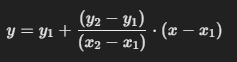

- y1 ve y2 -> Eksik verinin iki komşu noktası
- x1 ve x2 -> Bu noktaların indeksleri (zaman veya pozisyon bilgisi).
- x -> eksik verinin indeksi

Koordinat Sistemleri ve	Kullanım Alanları:

- **ECEF**	Uydular arası mesafe, küresel analizler, uydu yörüngelerinin modellenmesi.
- **Jeodezik**, arazi ölçümü, kullanıcı odaklı konum gösterimi.
- **ENU**,	Yerel düzlemde hareket analizi (örneğin, bir aracın kuzeye doğru hızı), yerel navigasyon

In [9]:
# Simple outlier detection and interpolation
def exclude_interpolate_outlier(x_wls, v_wls):
    """
    Args:
        x_wls : Konum vektörü
        v_wls : Hız vektörü
    """

    # z ekseninde hız için eşik değerimizi tanımlayalım (m/s)
    v_up_th = 2.0


    # Konum ve hız bilgilerini ECEF'ten farklı bir koordinat sistemine dönüştüreceğiz:
      # Konumu, ECEF'ten Jeodezik koordinata çevirdik. Jeodezik kkoordinatlar, dünya yüzeyi üzerindeki noktaları daha kolay temsil etmemizi sağlayacak
      # Hızı, ECEF'ten ENU koordinat sistemine çevirdik. ENU(Earth North Up), aracın hareket yönünü belirlememizi ve analiz etmemizi kolaylaştırır.
    x_llh = np.array(pm.ecef2geodetic(x_wls[:, 0], x_wls[:, 1], x_wls[:, 2])).T
    v_enu = np.array(pm.ecef2enuv(v_wls[:, 0], v_wls[:, 1], v_wls[:, 2], x_llh[0, 0], x_llh[0, 1])).T


    # Hız vektörü belirlediğiiz eşik değerin üstündyse aykırı değer ataması yapıp uerine NaN değeri atıyoruz
    # Burada aslında bahsettiğimiz şey arabaların tümseklerden geçerkenki yukarı doğru olan hız vektörü
    idx_v_out = np.abs(v_enu[:, 2]) > v_up_th
    v_wls[idx_v_out, :] = np.nan


    # Konum verilerindeki eksik değerleri interpolasyon yöntemi ile dolduracağız
    x_df = pd.DataFrame({'x': x_wls[:, 0], 'y': x_wls[:, 1], 'z': x_wls[:, 2]}) # konum verilerini df'e dönüştürdük
    x_df = x_df.interpolate(limit_area='outside', limit_direction='both') # interpolasyon ile eksik verileri doldurduk (komşu veri noktalarına göre)


    # Aynı şekilde Hız verilerindeki eksik değerleri interpolasyon yöntemi ile dolduracağız
    v_df = pd.DataFrame({'x': v_wls[:, 0], 'y': v_wls[:, 1], 'z': v_wls[:, 2]})
    v_df = v_df.interpolate(limit_area='outside', limit_direction='both')
    v_df = v_df.interpolate('spline', order=3) # kübik spline yöntemi kullandık. Bu sayede daha akıcı bir tahmin elde edebileceğiz


    return x_df.to_numpy(), v_df.to_numpy()

# 8- Kalman Filteleme ve Pürüzsüzleştirme

Kalman filtresi, dinamik sistemlerde en uygun durum tahminini sağlayan ve zaman serisi verilerinin analizi için kullanılan bir algoritmadır. Bu filtre, önceki durum bilgilerine dayanarak tahmin yapar ve yeni ölçümleri entegre ederek sistemin mevcut durumunu optimize eder.

İlk olarak, başlangıç durumu belirlenir ve tahmin yapılır. Ardından, bir ölçüm elde edilir ve model ile ölçüm entegrasyonu Kalman kazancı ile yapılır; kazanç, model ve ölçüm belirsizliklerine göre ayarlanır. Bu tekrar eden tahmin-güncelleme süreci, daha doğru tahminler yapılmasını sağlar

GNSS konum iyileştirme sistemlerinde, ölçüm gürültülerini ve hataları azaltmak için yaygın olarak kullanılmaktadır. GNSS verilerinin Kalman filtresiyle işlenmesinde durum ve gözlem bilgilerini entegrasyon yoluyla daha hassas bir konum tahmini yapılabilir. Kalman filtresi, sistemdeki gürültü ve belirsizlikleri en aza indirgeyerek en olası durumu belirlemeyi amaçlar.

In [10]:
# Kalman filter
def Kalman_filter(zs, us, phone):
    """
    Args:
        zs : konum ölçümleri (her gözlem 3 bileşenden oluşacak -> x y z)
        us : hız bilgisi  (her gözlem 3 bileşenden oluşacak -> x y z)
        phone : kullanılan telefon modeli
    """
    # TANIMLAMALAR:

    # Hızın Standart Sapması
    sigma_v = 0.6 if phone == 'XiaomiMi8' else 0.1 # Xiomi marka telefonlarda daha yüksek bir hata payı bırakıyoruz. Çünkü bu telefonlarda dah büyük hata payı olduğu varsayılıyor
    # Konumun Standart Sapması
    sigma_x = 5.0  # (metre)
    # Mahalanobis mesafesini belirliyoruz.
      # Mahalanobis mesafesi, gözlemlenen değerlerin mevcut modelden ne kadar farklı olduğunu ölçen bir istatistiksel ölçüt.
      # Kalman fitrlemenin geri beslemesinde eğer gözlem bu değerden büyükse aykırı gözlem olarak kabul edilecek ve filtreleme sürecine dahil edilmeyecek
      # Yani amacı, aykırı gözlemleri filtrelemek bir nevi
    sigma_mahalanobis = 30.0

    n, dim_x = zs.shape # Konum ölçümlerinin sayısı = n , durum vektörünün boyutu = dim_x (her ölçüm için 3 boyutlu olacak dolayısıyla dim_x = 3 olacak)
    F = np.eye(3)  # Geçiş matrisimiz (sisteminin durum geçişlerini tanımlayacak). 3x3'lük birim matrisi oluşturduk.
    Q = sigma_v**2 * np.eye(3)  # İşlem gürültüsü matrisimiz. Hızın standart sapmasının karesini F (geçiş matirisi) ile çarpıyoruz.
                                # Sİstemde beklenen gürültü miktarını temsil edecek. Zamanla biriken hataları modellemede kullanacağız

    H = np.eye(3)  # Sistemin gerçek durumunu ölçümlerle ilişkilendirmek için 3x3'lük birim matrisimiz (Ölçüm Matrisi)
    R = sigma_x**2 * np.eye(3)  # Ölçüm gürültüsü matrisimiz. Konumun standart sapmasının karesini birim matris ile çarpıyoruz.
                                # Ölçümlerin ne kadar gürültülü olduğunu veya ne kadar güvenilir olduğunu belirtecek. R ne kadar küçükse o kadar güvenilirdir.

    # Başlangıç ​​durumu ve kovaryans
    x = zs[0, :3].T  # başlangıç durumumuz (konum vektörünün transpozu)
    P = sigma_x**2 * np.eye(3)  # başlangıçtaki kovaryans yani belirsizlik
    I = np.eye(dim_x) # birim matrisimiz

    x_kf = np.zeros([n, dim_x]) # her adımında elde edilen durum vektörlerinin sırasıyla saklayacağımız dizi (başlangıç değeri = 0)
    P_kf = np.zeros([n, dim_x, dim_x])  # her adımında elde edilen kovaryans matrislerini sırasıyla saklayacağımız dizi (başlangıç değeri = 0)




    # KALMAN FİLTRELEME yapabiliriz artık:
    for i, (u, z) in enumerate(zip(us, zs)):
        # İlk adımımız
        if i == 0:
            x_kf[i] = x.T # ilk durumu kaydettik
            P_kf[i] = P # ilk kovaryansı kaydettik
            continue

        # Tahmin adımı
        x = F @ x + u.T # durumla ilgili yeni tahminimiz F@x + hızın transpozesi
        P = (F @ P) @ F.T + Q # bu tahminin kovaryansı. Ne kadar güvenilir olduğu

        # Mahalonabis mesafesini kullanarak aykırı değerleri kontrol ediyoruz. Eşik değerimizi yukarıda tanımlamıştık
        d = distance.mahalanobis(z, H @ x, np.linalg.pinv(P)) # z gözlemimiz , H@x tahminimiz , np.linalg.pinv(P) kovaryans matrisimiz(güvenilirliği ölçecek)

        # Güncelleme adımı.
        if d < sigma_mahalanobis: # Eğer mesafemiz en başta belirlediğimiz mahalonabis değerinden düşükse yani gözlem aykırı DEĞİLSE
            y = z.T - H @ x # gözlemimizle tahminimiz arasındaki fark
            S = (H @ P) @ H.T + R # sistemin güvenilirliğini ölçen kovaryans matrisi
            K = (P @ H.T) @ np.linalg.inv(S)  # kalman kazancımız. gözlemlerle tahminler arasındaki farkı ne kadar dikkate alacağımızı belirleyen bir katsayı
            x = x + K @ y # güncellenmiş durum vektörü
            P = (I - (K @ H)) @ P # başlangıçtaki kovaryans matrisini güncelliyoruz
        else: # aykırı ise
            P += 10**2*Q   # kovaryans matrisini artırarak gözlemlerle ilişkisini azaltacağız. Yani daha az güvenilirdir diyeceğiz

        x_kf[i] = x.T # durum vektörlerimiz
        P_kf[i] = P   # kovaryans vektörlerimiz

    return x_kf, P_kf





# KALMAN PÜRÜZSÜZLEŞTİRME
# İleri + geri Kalman filtresi ve pürüzsüzleştirme
  # Bu sayede verileri daha da hassaslaştırarak konum ve hız verilerinin doğruluğunu artıracağız

def Kalman_smoothing(x_wls, v_wls, phone):
    """
    Args:
        x_wls : Konum vektörü
        v_wls : Hız vektörü
        phone : Kullanılan telefon modeli
    """

    n, dim_x = x_wls.shape # aynı üstteki gibi konum vektörlerinin sayısı = n , durum vektörünün boyutu = dim_x (her ölçüm için 3 boyutlu olacak dolayısıyla dim_x = 3 olacak)

    # İleri filtreleme
    v = np.vstack([np.zeros([1, 3]), (v_wls[:-1, :] + v_wls[1:, :])/2]) # hız verilerinin ortak noktasını bulur (iki ardalık veri arasında)
    x_f, P_f = Kalman_filter(x_wls, v, phone) # Kalman filtresini çağırarak konum ve kovaryans tahmini yapıyoruz

    # Geri filtreleme
    v = -np.flipud(v_wls) # geri filtreleme yapacağımız için hız verilerinin sırasını tersine çevirdik
    v = np.vstack([np.zeros([1, 3]), (v[:-1, :] + v[1:, :])/2])
    x_b, P_b = Kalman_filter(np.flipud(x_wls), v, phone)  # Yine Kalman filtresini çağırdık. Bu sefer geçmişteki verileri göz önüne alarak daha doğru bir tahmin yapacağız

    # Pürüzsüzleştirme
    x_fb = np.zeros_like(x_f) # Hem ileri hem de geri yönde düzeltilmiş konum tahminleri
    P_fb = np.zeros_like(P_f) # Hem ileri hem de geri yönde düzeltilmiş hız tahminleri
    for (f, b) in zip(range(n), range(n-1, -1, -1)):
        P_fi = np.linalg.inv(P_f[f])  # ileri kovaryans matrisinin tersi
        P_bi = np.linalg.inv(P_b[b])  # Geri kovaryans matrisinin tersi

        P_fb[f] = np.linalg.inv(P_fi + P_bi)  # ileri ve geri kovaryan matrislerinin toplamının tersi. Bu sayede ileri ve geriyi birleştirdik
        x_fb[f] = P_fb[f] @ (P_fi @ x_f[f] + P_bi @ x_b[b]) # ileri ve geri tahminleri birleştirdik ve pürüzsüzleştirmeyi yapmış olduk

    return x_fb, x_f, np.flipud(x_b)  # ileri-geri konum tahmini , ileri konum tahmini ve geri konum tahminini geri döndürdük

# 9- Veri Setimize Bu Ön İşleme Tekniklerinin Uygulanması

In [12]:
# Veri Setimizin bulunduğu path'i tutuyoruz
path = '/content/drive/MyDrive/BitirmeProjesi/smartphone-decimeter-2022/train/2021-07-19-US-MTV-1/GooglePixel4'
# Veri setindeki drive ve phone değişkenlerini ayrırarak  sürüş oturumunu (2021-07-19 US-MTV-1 / 19 Temmuz 2021 Amerika) ve o sürüşte kullanılan telefonu elde edeceğiz
drive, phone = path.split('/')[-2:]


# Drive'ımızda depoladığımız GNSS ölçüm veri seti ile gerçek konum verilerini ieçeren dataframe'lerimiz
gnss_df = pd.read_csv(f'{path}/device_gnss.csv')  # GNSS verileri
gt_df = pd.read_csv(f'{path}/ground_truth.csv')  # gerçek veriler

# GNSS verilerimize yazdığımız 'point_positioning' fonksiyonumuzu uygulayarak kullanıcının konum ve hız tespitini yapıyoruz
utc, x_wls, v_wls = point_positioning(gnss_df)

# Konum ve hız vektörlerindeki aykırı ya da NaN değerleri yazdığımız "exclude_interpolate_outlier" fonksiyonu ile interpolasyonla tespit ediyoruz ve dolduruyoruz
x_wls, v_wls = exclude_interpolate_outlier(x_wls, v_wls)

# Yazdığımız "Kalman_smoothing" fonksiyonu ile hız ve konum tahminimizin doğruluğunu artırıyoruz
x_kf, _, _ = Kalman_smoothing(x_wls, v_wls, phone)

# Veri setini ECEF koorinat sisteminden Jeodezik Koor. Sis. çevirerek enlem, boylam ve yükseklik sistemine dönüştürüyoruz
# 10. bölümde bunları kullanacağız
llh_wls = np.array(pm.ecef2geodetic(x_wls[:, 0], x_wls[:, 1], x_wls[:, 2])).T # "point_positioning"den elde edilen hız ve konum koordinatları
llh_kf = np.array(pm.ecef2geodetic(x_kf[:, 0], x_kf[:, 1], x_kf[:, 2])).T # kalman filtresi sonucu iyileştirilen hız ve konum koordinatları

# Gerçek verilerle (gt_df) karşılaştırmak için fonksiyonlar sonucu ortaya çıkacak "gnss_df"imizi hazırlayarak referans noktası (base line) oluşturuyoruz
x_bl = gnss_df.groupby('TimeNanos')[['WlsPositionXEcefMeters', 'WlsPositionYEcefMeters', 'WlsPositionZEcefMeters']].mean().to_numpy() # GNSS verilerinde her zaman dilimi için pozisyon tahminlerinin ortalaması
llh_bl = np.array(pm.ecef2geodetic(x_bl[:, 0], x_bl[:, 1], x_bl[:, 2])).T # üstteki tahmini enlem, boylam ve yükseklik formatına dönüştürdük

  0%|          | 0/1896 [00:00<?, ?it/s]

# 10- Karşılaştırmak İçin Skor Hesaplanması ve Skorların Yorumlanması

Vincenty Formülü, bir kürenin yüzeyindeki iki nokta arasındaki mesafeyi hesaplamak için kullanılan yöntemdir.
<br></br>

<h3 style="color:blue;">Skorların Yorumlanması</h3>

1. **Referans Noktası Skoru (2.1929 metre):**

- Bu skor, temel modelin performansını gösterir.
- Düşük doğruluk beklediğimiz bir referans olarak düşünebiliriz.
<br></br>

2. **WLS Skoru (1.9769 metre):**

- Weighted Least Squares (WLS), GNSS verilerindeki hataları azaltmak için kullandığımız bir yöntemdi zaten.
- Baseline skorundan daha düşük bir değer, bu yöntemin ile birlikte pozisyon doğruluğunu artırdığımızı gösterir.
- Bu yöntemle elde ettiğimiz skorumuz Baseline'a göre yaklaşık %9.85 iyileşme gösteriyor.
<br></br>

3. **Kalman Filtresi Skoru (1.1443 metre):**

- Kalman filtresi, zaman serisi verilerindeki hataları daha ileri düzeyde filtrelemesi ve pozisyon tahminlerini daha da iyileştirmesi için kullanmıştık.
- Bu skor genellikle en düşük olmalıdır.
- Eğer gerçek dünya uygulamalarında yüksek hassasiyet elde etmemiz gerekiyorsa (örneğin, otonom araçlar, navigasyon sistemleri), Kalman filtresiyle elde ettiğimiz sonuçlar daha kritiktir.
- Kalman Filtresi ile elde ettiğimiz skor WLSE'e göre %42.12 , Baseline'a göre ise yaklaşık %47.82  daha iyi bir sonuç sağlıyor.
<br></br>

Genel olarak baktığımızda; sonuçlar, her adımda modelin doğruluğunun arttığını ve Kalman filtresi ile iyi bir doğruluk seviyesine ulaştığımızı gösteriyor.


In [13]:
# Bu fonksiyon vincenty yöntemini kullanarak iki enlem ve boylam noktasını arasındaki mesafeyi hesaplayacak
def vincenty_distance(llh1, llh2):
    """
    Args:
        llh1 : İlk noktanın enlem ve boylam bilgisi (derece cinsinden)
        llh2 : İkinci noktanın enlem ve boylam bilgisi (derece cinsinden)
    Returns:
        d : İki nokta arasındaki mesafe (m)
    """
    d, az = np.array(pmv.vdist(llh1[:, 0], llh1[:, 1], llh2[:, 0], llh2[:, 1])) # PyMap kütüphanesindeki vincenty uzaklık formülünü kullandık mesaheyi hesaplamak için
                                                                                # buradaki az -> azimut açısı = bir noktanın diğer bir noktaya olan yönünü belirten bir açı ...
                                                                                # ... iki nokta arasındaki yönü bulmak için kullanacağız. Şu an burada kullanmadık

    return d





# Bu fonks ile GNSS ölçümleriyle gerçek ölçümleri (ground_truth) karışılştırarak skoru hesaplayacağız
def calc_score(llh, llh_gt):
    """
    Args:
        llh : Tahmin edilen enlem ve boylamlar (derece cinsinden)
        llh_gt : Gerçek enlem ve boylamlar ("ground truth")
    Returns:
        score : (m)
    """
    d = vincenty_distance(llh, llh_gt)  # tahmin ve gerçek konum arasındaki uzaklığı tuttuk
    score = np.mean([np.quantile(d, 0.50), np.quantile(d, 0.95)]) # 0.5'lik çeyreklik -> tipik hatayı gösterecek
                                                                  # 0.95'lik çeyreklik -> yüksek hataları (GPS sinyali kötü olan bölgelerde ise) gösterecek
                                                                  # Bu ikisinin ortalamasını alarakhem ortalama doğruluğu hem de kötü senaryoları aynı anda göz önünde bulunduracağız

    return score




# Gerçek konum verilerimizi Enlem ve Boylam olarak alarak karşılaştırmak için numpy'a dönüştürüyoruz
llh_gt = gt_df[['LatitudeDegrees', 'LongitudeDegrees']].to_numpy()

# GNSS verilerimizin skorlarını gerçek verilere olan uzaklığını bulacağız
vd_bl = vincenty_distance(llh_bl, llh_gt) # referans noktamızla (ön işlemeler sonucu) gerçek tahminler arası uzaklık
vd_wls = vincenty_distance(llh_wls, llh_gt) # Dayanıklı Ağırlıklı En Küçük Kareler Yönemi (point_positioning sonucu) ile gerçek tahminler arası uzaklık
vd_kf = vincenty_distance(llh_kf, llh_gt) # Kalman Filtresi sonucu ile gerçek tahminler arası uzaklık

# Bu 3 uzaklığın da ayrı ayrı skorunu hesaplayacağız
score_bl = calc_score(llh_bl, llh_gt) # Referans Noktası (Baseline) skoru
score_wls = calc_score(llh_wls, llh_gt) # WLS skoru
score_kf = calc_score(llh_kf[:-1, :], llh_gt[:-1, :]) # Kalman filtresi skoru

print(f'Referans Noktası (Baseline) Skoru: {score_bl:.4f} [metre]')
print(f'WLS Yöntemi Skoru: {score_wls:.4f} [metre]')
print(f'Kalman Filtresi skoru: {score_kf:.4f} [metre]')

Referans Noktası (Baseline) Skoru: 2.1929 [metre]
WLS Yöntemi Skoru: 1.9769 [metre]
Kalman Filtresi skoru: 1.1443 [metre]


# 11- Konum ve Hız Hatalarının Görselleştirilmesi

<h3>Grafiklerin Yorumlanması</h3>

- İlk Grafik

Bu grafikte üstte skorunu hesapladığımız üç farklı yöntemin mesafe hatalarını karşılaştırılıyoruz ve görselde her bir yöntemin performansını detaylı bir şekilde görebiliyoruz.

  - Referans Noktası (Baseline): Mavi çizgi ile gösteriliyor. Herhangi bir iyileştirme veya filtreleme uygulanmamış ham verilerin mesafe hatasını temsil ediyor.

  - WLS Yöntemi: Turuncu çizgi ile gösteriliyor. Ağırlıklı en küçük kareler (Weighted Least Squares) yöntemi ile iyileştirilmiş tahminler içeriyor.

  - Kalman Filtresi: Yeşil çizgi ile gösteriliyor. WLS tahminlerini Kalman filtresiyle daha da iyileştiriyor.

Baseline ve WLS yönteminde gözlenen ani sıçramalar, GNSS ölçümlerindeki gürültü ve aykırı değerlerden kaynaklanıyor şeklinde bir yorumda bulunabiliriz. Ancak Kalman filtresi ile bu sıçramaları etkin bir şekilde filtreleyerek en iyi skoru almaya daha da yaklaşıyoruz.

WLS yöntemi, ham veriye göre bir iyileşme sağlıyor ancak aykırı değerlere duyarlılığı nedeniyle bazı veri noktalarında yüksek hata gösteriyor. Kalman filtresinin eklenmesiyle hatalar daha düzenli ve tutarlı hale gelmiş.
<br></br>

- İkinci Grafik

Bu grafikte, tahmin ettiğimiz hızlar ile gerçek hızlar arasındaki farkın oldukça düşük ve tutarlı olduğu görünüyor. Bu, da sistemimizin genel olarak güvenilir bir şekilde çalıştığını destekliyor.

ELde ettiğimiz 0.1265'lik bir RMSE değeri de tahminlerin büyük oranda doğru olduğunu destekliyor.

Zaman zaman grafikte ani yükselişler olduğunu gözlemleyebiliriz. Bunun sebeplerini basitçe şu şekilde açıklayabiliriz:
  - GPS sinyallerindeki kayıplar (ağaçlık yerler, yüksek binalar)
  - Aracın hızındaki ani değişimler
  - Aracın ani manevraları

  Bu hataları azaltmak için zaten Kalman Filtresi , WLS gibi yöntemler ayrıca interpolasyon gibi eksik verileri doldurma gibi ön işleme uygulamaları yapmıştık. Ancak modelin doğruluğunu daha da artırmak için LSTM, ANN , RNN gibi makine ve derin öğrenme algoritmaları da kullanabiliriz.


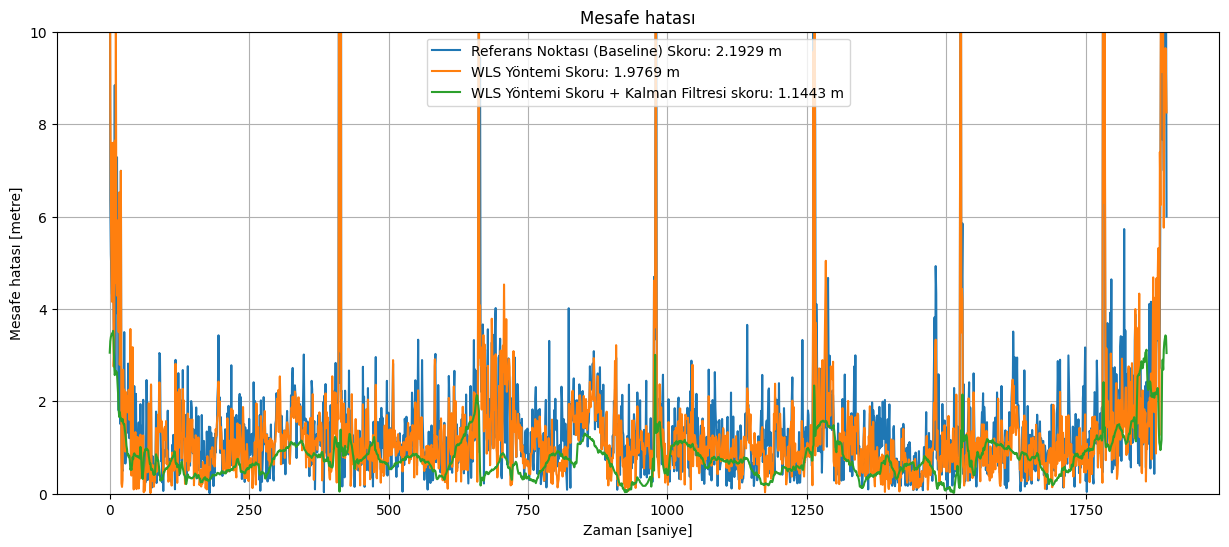

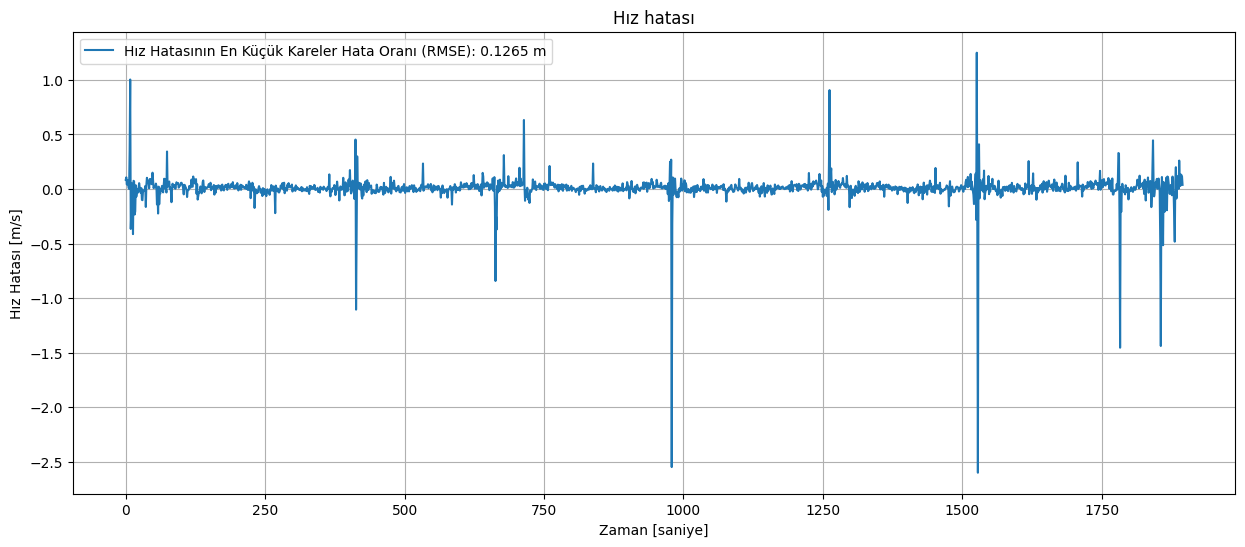

In [15]:
# Skorlarımızı görselleştirerek mesafe hatasını gösterelim
plt.figure(figsize=(15,6))
plt.title('Mesafe hatası')
plt.xlabel('Zaman [saniye]')
plt.ylabel('Mesafe hatası [metre]')
plt.plot(vd_bl, label=f'Referans Noktası (Baseline) Skoru: {score_bl:.4f} m')
plt.plot(vd_wls, label=f'WLS Yöntemi Skoru: {score_wls:.4f} m')
plt.plot(vd_kf, label=f'WLS Yöntemi Skoru + Kalman Filtresi skoru: {score_kf:.4f} m')
plt.legend()
plt.grid()
plt.ylim([0, 10])

# Hızın hatasını hesaplayalım
speed_wls = np.linalg.norm(v_wls[:, :3], axis=1)  # 4. kısımda oluşturduğumuz ve hız tahminlerini tuttuğumuz v_wls matrisinin ilk 3 sütununuu alarak hız bileşenlerini tutuyoruz (xyz)
                                                  # np.linalg.norm: her bir vektörün büyüklüğünü (normunu) hesaplayacak. Burada, üç boyutlu hız vektörünün büyüklüğünü hesaplanarak skaler bir hız değerine dönüştüreceğiz.
speed_gt = gt_df['SpeedMps'].to_numpy() # gerçek hız verilerimizi tutuyoruz
speed_rmse = np.sqrt(np.sum((speed_wls-speed_gt)**2)/len(speed_gt)) # ilk başta tuttuğumuz tahmini verilerle ikinci olarak tututğumuz gerçek değerler arasındaki farkımız

# Hesapladığımız hız hatasını görselleştirelim
plt.figure(figsize=(15,6))
plt.title('Hız hatası')
plt.xlabel('Zaman [saniye]')
plt.ylabel('Hız Hatası [m/s]')
plt.plot(speed_wls - speed_gt, label=f'Hız Hatasının En Küçük Kareler Hata Oranı (RMSE): {speed_rmse:.4f} m')
plt.legend()
plt.grid()